In [1]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.signal import convolve2d,fftconvolve
from scipy.stats import norm
from tqdm import tqdm

#### Get an estimate for f using <br><br> (i) Wiener filter <br> (ii) using MAP estimation <br> (iii) any deep network based approach under the following cases.

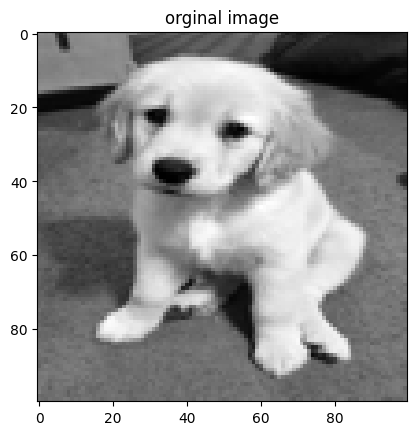

In [4]:
img = Image.open("cute_pup.jpg")
img = img.resize((100,100))
img = np.array(img)
img = 0.3 * img[:,:,0] + 0.6 * img[:,:,1] + 0.1 * img[:,:,2]
plt.imshow(img,cmap='gray')
plt.title("orginal image")
plt.show()

### case 1

True

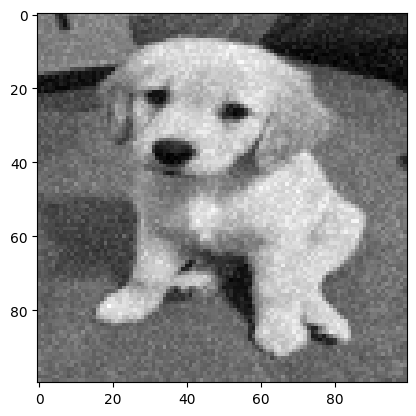

In [28]:
A = np.identity(img.shape[0])
n = np.clip(np.random.normal(10,10,size=img.shape),0,255)
g_img = (A @ img) + n 
plt.imshow(g_img,cmap='gray')
cv2.imwrite("noise.jpg",g_img)

### Wiener's Filter

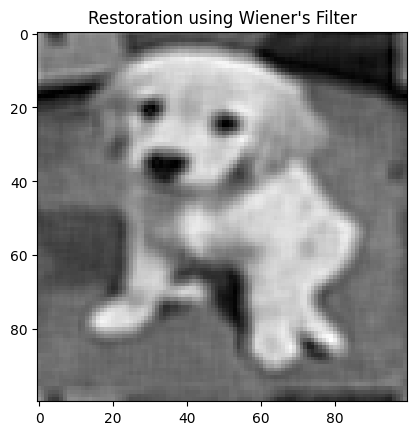

In [36]:
H = np.fft.fft2((1/5)* np.ones((5,5)),s=img.shape)
K = 12 * np.ones(H.shape)
H_1 = np.conj(H)
Wiener_filter = H_1/((H*H_1) + K)
G = np.fft.fft2(g_img)
filtered_img = Wiener_filter * G
filtered_img = np.fft.ifft2(filtered_img)
plt.imshow(np.abs(filtered_img),cmap='gray')
plt.title("Restoration using Wiener's Filter")
plt.show()

### MAP Estimation

In [10]:
def estimate_psf(degraded_image, iterations):
    # Initialize PSF as a delta function (impulse)
    psf = np.zeros_like(degraded_image)
    psf[degraded_image.shape[0] // 2, degraded_image.shape[1] // 2] = 1.0
    
    # Perform Richardson-Lucy deconvolution iterations
    for i in range(iterations):
        # Estimate the restored image using the current PSF
        restored_image = deconvolve(degraded_image, psf)
        
        # Estimate the error image (residual)
        error_image = degraded_image / np.maximum(restored_image, 1e-5)
        
        # Update PSF using the error image
        psf = update_psf(psf, error_image)
        
        # Normalize PSF to sum to 1
        psf /= np.sum(psf)
        
    return psf

def deconvolve(image, psf,epsilon=1e-10):
    # Perform Richardson-Lucy deconvolution
    restored_image = np.real(np.fft.ifft2(np.fft.fft2(image) / np.maximum(np.fft.fft2(psf),epsilon)))
    return restored_image

def update_psf(psf, error_image):
    # Update PSF using error image (e.g., by convolving error image with the transpose of the image)
    updated_psf = np.real(np.fft.ifft2(np.fft.fft2(error_image) * np.conj(np.fft.fft2(psf))))
    return updated_psf


100%|██████████| 100/100 [00:00<00:00, 3736.21it/s]


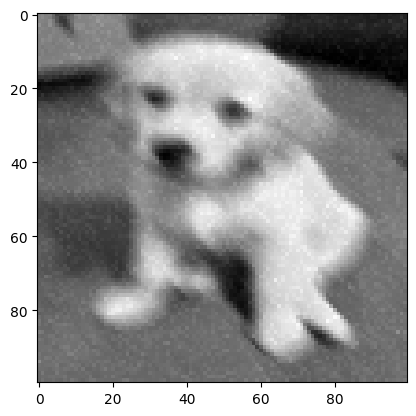

In [120]:
epochs = 100
new_out = g_img.copy()
FIL = (1/25) *  np.ones((5,5))
for i in tqdm(range(epochs)):
    output = cv2.filter2D(g_img,-1,np.ones((5,5)))
    error = np.exp(-2*(output - img))
    new_out -= np.real(np.abs(error))

# print(prob)
plt.imshow(new_out,cmap='gray')
plt.show()

### Deep Learning model

In [14]:
import replicate


# input = {
#     "image" : "https://github.com/vrs-darkness/Assignment/blob/main/IVP%20LAB/noise.jpg"
# }
api = replicate.Client(api_token="your-api-key")
output = api.run(
    "jingyunliang/swinir:660d922d33153019e8c263a3bba265de882e7f4f70396546b6c9c8f9d47a021a",
    input={
        "jpeg": 40,
        "image": "https://raw.githubusercontent.com/vrs-darkness/Assignment/main/IVP%20LAB/noise.jpg",
        "noise": 15,
        "task_type": "Real-World Image Super-Resolution-Large"
    }
)
print(output)

https://replicate.delivery/pbxt/FtgOAOkvKZp4Nli6OTeWutThaebKFDLP05VFfZAw0P26cSVlA/out.png


### case 2

In [79]:
h = np.identity(5)
n = np.clip(np.random.normal(10,30,size=img.shape),0,255)
g_img = np.add(cv2.filter2D(src=img,ddepth = -1,kernel = h),n)

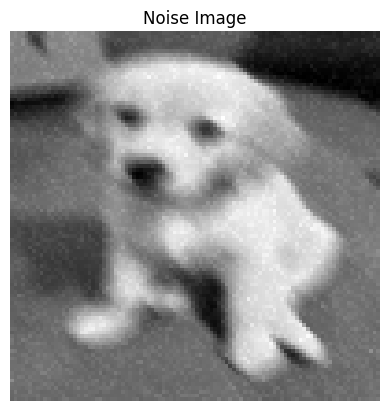

True

In [80]:
plt.imshow(g_img,cmap='gray')
plt.title("Noise Image")
plt.axis('off')
plt.show()
cv2.imwrite("shake-pup.jpg",g_img)

### Wiener's Filter

In [81]:
H = np.fft.fft2(h,s=img.shape)
K = 5
H_1 = np.conj(H)
Wiener_filter = H_1/(H * H_1 + K)
G = np.fft.fft2(g_img)
filtered_img = Wiener_filter * G
filtered_img = np.fft.ifft2(filtered_img)

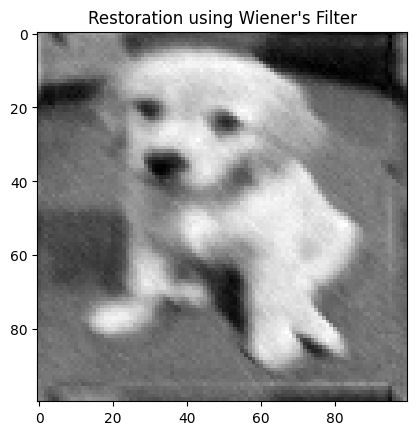

In [82]:
plt.imshow(np.abs(filtered_img),cmap='gray')
plt.title("Restoration using Wiener's Filter")
plt.show()

### Map Estimation

100%|██████████| 10/10 [00:00<00:00, 1080.06it/s]
/tmp/ipykernel_179247/1332923494.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.imshow(np.uint8(new_out),cmap='gray')


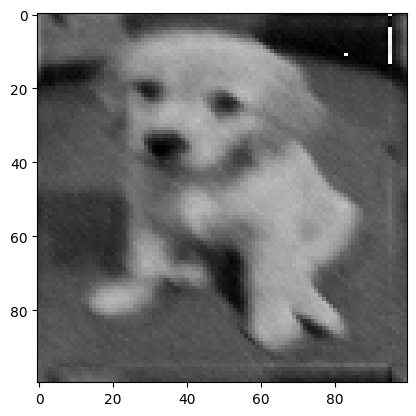

In [121]:
epochs = 10
new_out = filtered_img.copy()
FIL = (1/25) *  np.ones((5,5))
for i in tqdm(range(epochs)):
    output = cv2.filter2D(g_img,-1,FIL)
    error = np.exp(-2*(output - img))
    new_out -= np.real(np.abs(error))

# print(prob)
plt.imshow(np.uint8(new_out),cmap='gray')
plt.show()

### Deep Learning meathod

In [14]:
import replicate


# input = {
#     "image" : "https://github.com/vrs-darkness/Assignment/blob/main/IVP%20LAB/shake-pup.jpg",
#     "task_type" : "Image Denoising"
# }
output = api.run(
    "jingyunliang/swinir:660d922d33153019e8c263a3bba265de882e7f4f70396546b6c9c8f9d47a021a",
    input={
        "jpeg": 40,
        "image": "https://raw.githubusercontent.com/vrs-darkness/Assignment/main/IVP%20LAB/shake-pup.jpg",
        "noise": 15,
        "task_type": "Real-World Image Super-Resolution-Large"
    }
)
print(output)

https://replicate.delivery/pbxt/zeNmnFbO76T4P6vKI3GgPHfjnD5rBoi06huoANkMr1yKJpqSA/out.png


### END